In [22]:
# Step 1: Install gdown
!pip install gdown

# Step 2: Import the file from Google Drive
import gdown

# File ID and URL
file_id = "1Jhl4lWVCMsvuWzTVY7hYCE88AMv-f1-7"
url = f"https://drive.google.com/uc?id={file_id}"

# Output file name
output = "duolingo_data.csv"

# Step 3: Download the file
gdown.download(url, output, quiet=False)

# Step 4: Load the file into a DataFrame
import pandas as pd
df = pd.read_csv(output)

Downloading...
From (original): https://drive.google.com/uc?id=1Jhl4lWVCMsvuWzTVY7hYCE88AMv-f1-7
From (redirected): https://drive.google.com/uc?id=1Jhl4lWVCMsvuWzTVY7hYCE88AMv-f1-7&confirm=t&uuid=e28dfe06-06a7-4870-ac88-fd7b594b48f9
To: /content/duolingo_data.csv
100%|██████████| 409M/409M [00:02<00:00, 149MB/s] 



--- Dataset Overview ---
      rows  unique_users  unique_lexemes time_start   time_end  \
0  3795780         79694           16244 2013-03-01 2013-03-08   

   learning_languages  ui_languages  
0                   6             4  

--- Missing Values (%) ---
               column  missing_pct
0            p_recall          0.0
1           timestamp          0.0
2               delta          0.0
3             user_id          0.0
4   learning_language          0.0
5         ui_language          0.0
6           lexeme_id          0.0
7       lexeme_string          0.0
8        history_seen          0.0
9     history_correct          0.0
10       session_seen          0.0
11    session_correct          0.0
12                 ts          0.0
13   p_recall_clipped          0.0
14      delta_clipped          0.0
15               date          0.0


/tmp/ipython-input-2696511558.py:75: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gap_acc = df.groupby("delta_bucket")["p_recall_clipped"].mean().reset_index().dropna()
/tmp/ipython-input-2696511558.py:86: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  history_acc = df.groupby("history_seen_bucket")["p_recall_clipped"].mean().reset_index().dropna()


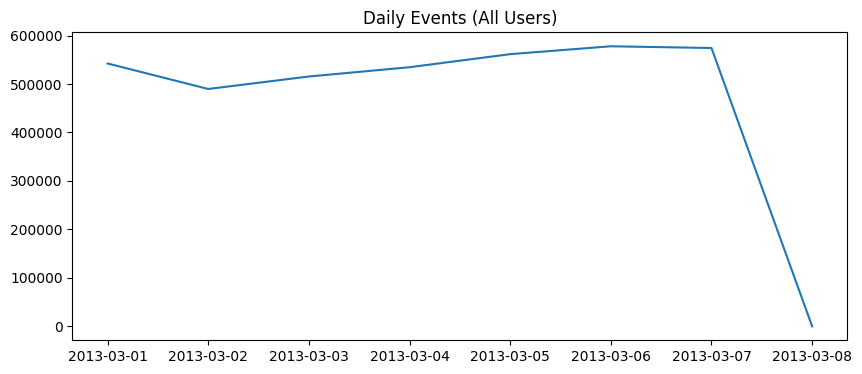

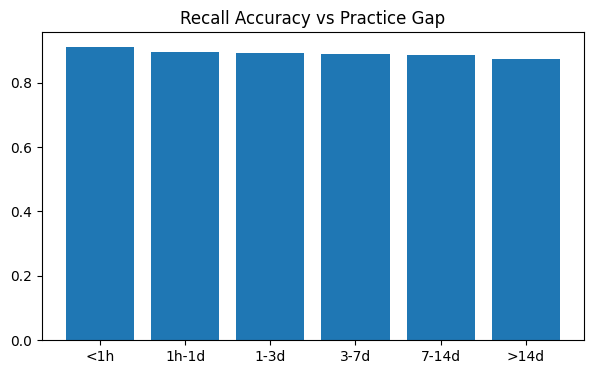

In [25]:
!pip install matplotlib pandas numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

dtypes_relaxed2 = {
    "p_recall": "float32",
    "timestamp": "object",
    "delta": "float32",
    "user_id": "object",
    "learning_language": "category",
    "ui_language": "category",
    "lexeme_id": "category",
    "lexeme_string": "category",
    "history_seen": "float32",
    "history_correct": "float32",
    "session_seen": "float32",
    "session_correct": "float32",
}

# Preprocessing
df["ts"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["date"] = df["ts"].dt.date

# Overview
overview = {
    "rows": len(df),
    "unique_users": df["user_id"].nunique(),
    "unique_lexemes": df["lexeme_id"].nunique() if "lexeme_id" in df.columns else pd.NA,
    "time_start": df["ts"].min(),
    "time_end": df["ts"].max(),
    "learning_languages": int(df["learning_language"].nunique()),
    "ui_languages": int(df["ui_language"].nunique()),
}
overview_df = pd.DataFrame([overview])
print("\n--- Dataset Overview ---")
print(overview_df)

# Missing values
missing_pct = df.isna().mean().sort_values(ascending=False).reset_index()
missing_pct.columns = ["column", "missing_pct"]
print("\n--- Missing Values (%) ---")
print(missing_pct)

# Sanity checks
if "p_recall" in df.columns:
    df["p_recall_clipped"] = df["p_recall"].clip(0, 1)

if "delta" in df.columns:
    delta_95 = df["delta"].dropna().quantile(0.95)
    df["delta_clipped"] = df["delta"].clip(upper=delta_95)
else:
    delta_95 = np.nan

# Daily aggregations
daily = (
    df.groupby("date")
      .agg(events=("user_id", "size"),
           active_users=("user_id", "nunique"),
           avg_p_recall=("p_recall_clipped", "mean"))
      .reset_index()
)

# Language popularity
lang_pop = df["learning_language"].value_counts().reset_index()
lang_pop.columns = ["learning_language", "events"]

# Gap vs Recall
delta_bins = [0, 60*60, 24*60*60, 3*24*60*60, 7*24*60*60, 14*24*60*60, np.inf]
delta_labels = ["<1h","1h-1d","1-3d","3-7d","7-14d",">14d"]

if "delta" in df.columns:
    df["delta_bucket"] = pd.cut(df["delta"], bins=delta_bins, labels=delta_labels, include_lowest=True)
    gap_acc = df.groupby("delta_bucket")["p_recall_clipped"].mean().reset_index().dropna()
else:
    gap_acc = pd.DataFrame(columns=["delta_bucket","p_recall_clipped"])

# Repetition vs Accuracy
if "history_seen" in df.columns:
    df["history_seen_bucket"] = pd.cut(
        df["history_seen"],
        bins=[-1,0,1,3,5,10,20,50,100, np.inf],
        labels=["0","1","2-3","4-5","6-10","11-20","21-50","51-100",">100"]
    )
    history_acc = df.groupby("history_seen_bucket")["p_recall_clipped"].mean().reset_index().dropna()
else:
    history_acc = pd.DataFrame(columns=["history_seen_bucket","p_recall_clipped"])

# User engagement metrics
user_agg = (
    df.groupby("user_id")
      .agg(events=("user_id","size"),
           unique_days=("date","nunique"),
           unique_lexemes=("lexeme_id","nunique"),
           avg_p_recall=("p_recall_clipped","mean"),
           median_delta=("delta","median"),
           total_session_seen=("session_seen","sum"),
           total_session_correct=("session_correct","sum"))
      .reset_index()
)

for col in ["events", "total_session_seen"]:
    maxv = user_agg[col].max() if col in user_agg.columns else 1.0
    user_agg[col + "_norm"] = user_agg[col] / maxv if maxv else 0.0

user_agg["engagement_score"] = (
    0.6 * user_agg["events_norm"] +
    0.3 * user_agg["total_session_seen_norm"] +
    0.1 * user_agg["avg_p_recall"].fillna(0)
)

# Most engaged user
top_user_id = user_agg.sort_values("engagement_score", ascending=False).iloc[0]["user_id"]
top_user_df = df[df["user_id"] == top_user_id].copy()

# Recap metrics
top_user_metrics = {
    "user_id": str(top_user_id),
    "events": len(top_user_df),
    "unique_lexemes": top_user_df["lexeme_id"].nunique(),
    "avg_p_recall": float(top_user_df["p_recall_clipped"].mean()),
    "median_delta_seconds": float(top_user_df["delta"].median()),
    "active_days": int(top_user_df["date"].nunique()),
    "primary_learning_language": str(top_user_df["learning_language"].mode().iloc[0]) if not top_user_df["learning_language"].mode().empty else "N/A",
}

# Platform averages
platform_avg = {
    "events_per_user": float(user_agg["events"].mean()),
    "avg_p_recall": float(df["p_recall_clipped"].mean()),
    "median_delta_seconds": float(df["delta"].median()),
    "active_days_per_user": float(user_agg["unique_days"].mean()),
}

# Streak
td = pd.Series(pd.to_datetime(top_user_df["date"]).unique())
td = pd.to_datetime(td).sort_values()
streak = max_streak = 0
prev = None
for d in td:
    if prev is None or (d - prev).days == 1:
        streak += 1
    else:
        streak = 1
    max_streak = max(max_streak, streak)
    prev = d
top_user_metrics["max_active_day_streak"] = int(max_streak)

# Plots
plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["date"]), daily["events"])
plt.title("Daily Events (All Users)")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(gap_acc["delta_bucket"].astype(str), gap_acc["p_recall_clipped"])
plt.title("Recall Accuracy vs Practice Gap")
plt.show()



In [ ]:
print("\n--- Duolingo User Insights & Personalized Recap ---\n")

# Overview
print("Overview:")
print(f"- Rows: {len(df):,}")
print(f"- Unique users: {df['user_id'].nunique():,}")
print(f"- Unique lexemes: {df['lexeme_id'].nunique()}")
print(f"- Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"- Learning languages: {df['learning_language'].unique().tolist()}")
print(f"- UI languages: {df['ui_language'].unique().tolist()}")

# Platform averages
print("\nPlatform Averages:")
print(f"- Events per user: {df.groupby('user_id').size().mean():.2f}")
print(f"- Avg p_recall: {df['p_recall'].mean():.3f}")
print(f"- Median gap (sec): {df['delta'].median():.0f}")
print(f"- Active days per user: {df.groupby('user_id')['date'].nunique().mean():.2f}")

# Most engaged user
top_user_id = df['user_id'].value_counts().idxmax()
top_user = df[df['user_id'] == top_user_id]

print(f"\nMost Engaged User (ID: {top_user_id}):")
print(f"- Events: {len(top_user):,}")
print(f"- Unique lexemes: {top_user['lexeme_id'].nunique()}")
print(f"- Avg p_recall: {top_user['p_recall'].mean():.3f}")
print(f"- Median gap (sec): {top_user['delta'].median():.0f}")
print(f"- Active days: {top_user['date'].nunique()}")
print(f"- Max active-day streak: {top_user.groupby('date').ngroup().max()+1}")  # simple streak approx
print(f"- Primary learning language: {top_user['learning_language'].mode()[0]}")



--- Duolingo User Insights & Personalized Recap ---

Overview:
- Rows: 3,795,780
- Unique users: 79,694
- Unique lexemes: 16244
- Time range: 2013-03-01 00:00:00 to 2013-03-08 00:00:00
- Learning languages: ['fr', 'en', 'de', 'es', 'it', 'pt']
- UI languages: ['en', 'es', 'pt', 'it']

Platform Averages:
- Events per user: 47.63
- Avg p_recall: 0.896
- Median gap (sec): 76095
- Active days per user: 1.86

Most Engaged User (ID: bcH_):
- Events: 4,202
- Unique lexemes: 629
- Avg p_recall: 0.464
- Median gap (sec): 810
- Active days: 7
- Max active-day streak: 7
- Primary learning language: en


In [ ]:
import pandas as pd
import numpy as np

# Ensure timestamp is datetime
df['ts'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['date'] = df['ts'].dt.date

# Clip recall between 0–1
df['p_recall'] = df['p_recall'].clip(0, 1)

# Daily Aggregates
agg_daily = (
    df.groupby("date")
      .agg(events=("user_id", "size"),
           active_users=("user_id", "nunique"),
           avg_p_recall=("p_recall", "mean"))
      .reset_index()
)
agg_daily.to_csv("agg_daily.csv", index=False)

# Language Popularity
agg_language_popularity = (
    df['learning_language']
      .value_counts()
      .reset_index()
      .rename(columns={"index": "learning_language", "learning_language": "events"})
)
agg_language_popularity.to_csv("agg_language_popularity.csv", index=False)

# Gap vs Accuracy (bucketed)
bins = [0, 3600, 86400, 3*86400, 7*86400, 14*86400, np.inf]
labels = ["<1h", "1h-1d", "1-3d", "3-7d", "7-14d", ">14d"]
df['delta_bucket'] = pd.cut(df['delta'], bins=bins, labels=labels, include_lowest=True)
agg_gap_vs_accuracy = (
    df.groupby("delta_bucket")['p_recall'].mean().reset_index()
)
agg_gap_vs_accuracy.to_csv("agg_gap_vs_accuracy.csv", index=False)

# Repetition vs Accuracy
df['history_seen_bucket'] = pd.cut(
    df['history_seen'],
    bins=[-1,0,1,3,5,10,20,50,100,np.inf],
    labels=["0","1","2-3","4-5","6-10","11-20","21-50","51-100",">100"]
)
agg_repetition_vs_accuracy = (
    df.groupby("history_seen_bucket")['p_recall'].mean().reset_index()
)
agg_repetition_vs_accuracy.to_csv("agg_repetition_vs_accuracy.csv", index=False)

# User Metrics
agg_user_metrics = (
    df.groupby("user_id")
      .agg(events=("user_id","size"),
           unique_days=("date","nunique"),
           unique_lexemes=("lexeme_id","nunique"),
           avg_p_recall=("p_recall","mean"),
           median_delta=("delta","median"),
           total_session_seen=("session_seen","sum"),
           total_session_correct=("session_correct","sum"))
      .reset_index()
)
agg_user_metrics.to_csv("agg_user_metrics.csv", index=False)

/tmp/ipython-input-3565630011.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("delta_bucket")['p_recall'].mean().reset_index()
/tmp/ipython-input-3565630011.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("history_seen_bucket")['p_recall'].mean().reset_index()


In [15]:
import pandas as pd


df = pd.read_csv(output, usecols=[
    "user_id","p_recall","delta","session_seen","session_correct"
])

# Convert to numeric safely
df["p_recall"] = pd.to_numeric(df["p_recall"], errors="coerce").clip(0,1)
df["delta"] = pd.to_numeric(df["delta"], errors="coerce")
df["session_seen"] = pd.to_numeric(df["session_seen"], errors="coerce")
df["session_correct"] = pd.to_numeric(df["session_correct"], errors="coerce")

# Aggregate by user
user_agg = df.groupby("user_id").agg(
    events=("user_id","size"),
    avg_p_recall=("p_recall","mean"),
    mean_delta_seconds=("delta","mean"),
    total_session_seen=("session_seen","sum"),
    total_session_correct=("session_correct","sum")
).reset_index()

# Save file
user_agg.to_csv("agg_user_metrics.csv", index=False)
print("agg_user_metrics.csv created")


agg_user_metrics.csv created
